In [308]:
import os
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools
import seaborn as sns
import numpy as np
# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# GLOBAL VARIABLES

seed = 7

## Reading the dataset

In [309]:
# Load the image file of dataset
testimages = np.load('testimage.npy')

# Load the labels file of dataset
testlabels = pd.read_csv('testLabels.csv')
# Load the image file of dataset
trainimages = np.load('trainimage.npy')

# Load the labels file of dataset
trainlabels = pd.read_csv('trainLabels.csv')

## Overview of the Data set

In [310]:
print(trainimages.shape)
print(trainlabels.shape)
print(testimages.shape)
print(testlabels.shape)

(251, 128, 128, 3)
(251, 1)
(66, 128, 128, 3)
(66, 1)


#### There are 251 RGB images in train and 66 RGB images in test data and are of shape 128 x 128 each. As mentioned, each image is an RGB image having 3 channels

#### Let's Plot first 8 images

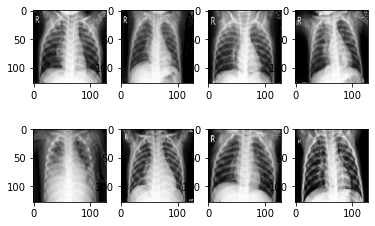

In [311]:
# Show some example images in test data
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainimages[i])

#### Let's understand if the dataset is imbalanced or not

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

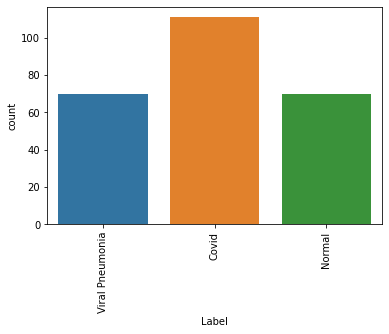

In [312]:
sns.countplot(trainlabels['Label'])
plt.xticks(rotation='vertical')

#### As you can see from the above plot, the dataset is quite balanced. But,we might need to stratify 

## Exploratory Data Analysis

### Plotting mean images

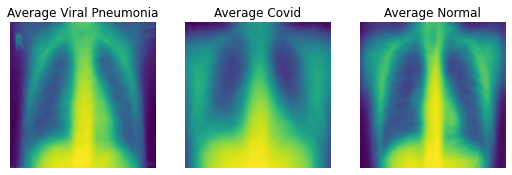

In [313]:
def find_mean_img(full_mat):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((150,150))
  
    return mean_img

CATEGORIES=trainlabels['Label'].unique()
d={ i:[] for i in CATEGORIES}

for i in trainlabels.index:
  gray = cv2.cvtColor(trainimages[i], cv2.COLOR_BGR2GRAY)
  gray = cv2.resize(gray,(150,150))
  d[trainlabels['Label'][i]].append(gray)

l=[]
for i in d.keys():
  l.append(find_mean_img(d[i]))

plt.subplots(figsize=(12,12))
for i in range(len(l)):
    plt.subplot(3,4,i + 1,title='Average '+list(d.keys())[i])
    plt.imshow(l[i])
    plt.axis('off')

### From above images its clear that person with Covid have small Blue shaded ribcage compared to Viral Pneumonia and Normal person

### The Average Covid lung image has shortened lung capacity, followed by Viral Pneumonia and normal person

## Data Preprocessing: Image Preprocessing
### Apply image processing:

##### It is a very important step to perform image preprocessing. Preprocessing an image is an intensive task. We will be performing the following steps in order to process the images

###### Convert the RGB images into HSV

###### The HSV model describes colors similarly to how the human eye tends to perceive color. RGB defines color in terms of a combination of primary colors. In situations where color description plays an integral role, the HSV color model is often preferred over the RGB model.

###### 'Hue' represents the color, 'Saturation' represents the amount to which that respective color is mixed with white and 'Value' represents the amount to which that respective color is mixed with black (Gray level).

###### HSV color space is more often used in computer vision owing to its superior performance compared to RGB color space in varying illumination levels. Often thresholding and masking is done in HSV color space. So it is very important to know the HSV values of the color we want to filter out.

In RGB, we cannot separate color information from luminance. HSV or Hue Saturation Value is used to separate image luminance from color information.

In this problem, color is an important factor in identifying the plant species. Hence converting BGR TO HSV is a good idea.

In order to remove the noise, we will have to blur the images (Gaussian Blurring)

In order to remove the background, we will have to create a mask.

Creating a mask will remove the noise. We have then applied some morphological transformation (closing=Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.) to remove the imperfections from the image.

Visualize data after pre-processing.



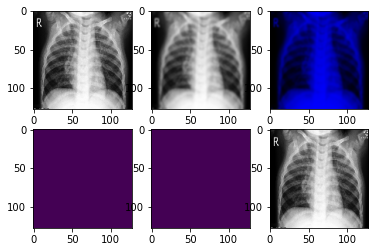

# CLEANED IMAGES


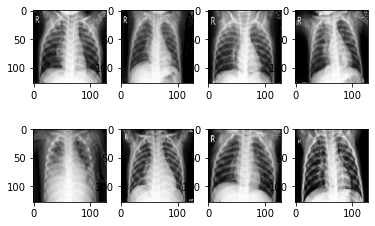

In [314]:
new_train = []
sets = []; getEx = True
for i in trainimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) #Using BGR TO HSV conversion. reason is mentioned above
    #HSV Bou daries for the Green color (GREEN PARAMETERS)
    lower = (0,0,0)
    upper = (255,255,255)
    mask = cv2.inRange(hsv,lower,upper) # create a mask 
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) #getting structring element ( kernal) of sie 11x11
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc) # applying morphological transformation ( closing operation ) to remove imperfections from the binary image ( mask)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)
print("# CLEANED IMAGES")
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

### Normalizing Data set

In [315]:
# Normalize image data.
new_train = trainimages / 255
test = testimages/255

#### Making the data compatible:
###### Convert labels from digits to one hot vectors.
###### Check the shape of the data. Reshape the data into shapes compatible with Keras models, if already not compatible

In [316]:
#from keras.utils.np_utils import to_categorical

In [317]:
# Convert labels from digits to one hot vectors.


from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(trainlabels)


In [318]:
print(y.shape)
print(new_train.shape)

(251, 3)
(251, 128, 128, 3)


In [319]:
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(new_train,y , test_size=0.1, random_state=seed,stratify=y)

In [320]:
print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)

(225, 128, 128, 3)
(225, 3)
(26, 128, 128, 3)
(26, 3)


#### We have used stratify to get an almost equal distribution of classes in the test and train set. Checking the class proportion for both the sets

### Building the CNN:
##### Define layers.
##### Set the optimizer and loss function.

In [321]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
#from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam

# Set the CNN model 
batch_size=None


model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(3, activation = "softmax"))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 64, 64, 16)      

In [322]:
from tensorflow.keras.optimizers import Adam

In [323]:
#Defining thr optimizer and loss function 
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

C:\Users\p00137247\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [324]:
# fitting the model with epochs = 10 
history=model.fit(x_train, y_train, epochs = 50, validation_split=0.1,batch_size = batch_size)

Epoch 1/50
7/7 [==============================] - 4s 472ms/step - loss: 1.1315 - accuracy: 0.3168 - val_loss: 1.0916 - val_accuracy: 0.3913
Epoch 2/50
7/7 [==============================] - 3s 425ms/step - loss: 1.0812 - accuracy: 0.4505 - val_loss: 1.0914 - val_accuracy: 0.3913
Epoch 3/50
7/7 [==============================] - 3s 496ms/step - loss: 1.0833 - accuracy: 0.4455 - val_loss: 1.0962 - val_accuracy: 0.3913
Epoch 4/50
7/7 [==============================] - 3s 410ms/step - loss: 1.0750 - accuracy: 0.4455 - val_loss: 1.0976 - val_accuracy: 0.3913
Epoch 5/50
7/7 [==============================] - 3s 425ms/step - loss: 1.0694 - accuracy: 0.4455 - val_loss: 1.0977 - val_accuracy: 0.3913
Epoch 6/50
7/7 [==============================] - 4s 538ms/step - loss: 1.0758 - accuracy: 0.4455 - val_loss: 1.0933 - val_accuracy: 0.3913
Epoch 7/50
7/7 [==============================] - 4s 637ms/step - loss: 1.0659 - accuracy: 0.4455 - val_loss: 1.0879 - val_accuracy: 0.3913
Epoch 8/50
7/7 [====

### Plotting the training and validation accuracy:

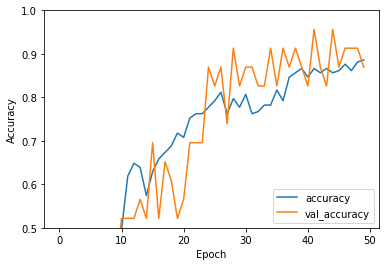

In [325]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

In [326]:
# Evaluate the model.

score = model.evaluate(x_validate, y_validate, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.48893335461616516
Test accuracy: 0.807692289352417


In [327]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 19

#### Data Augmentation (Regularization)¶
###### Data Augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data Augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks in order to help regularize them and reduce overfitting.

In [332]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(new_train)

### Dividing the training data into train and validation/dev set from X_train

In [336]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(new_train,y , test_size=0.1, random_state=seed,stratify=y)

In [337]:
X_train.shape

(225, 128, 128, 3)

### Defining the Model

In [338]:
# Set the CNN model 
batch_size=None
model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.2))


model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.4))



model1.add(GlobalMaxPooling2D())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(3, activation = "softmax"))
model1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 64, 64, 64)      

In [339]:
#Defining thr optimizer and loss function 
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#model1.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model1.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

C:\Users\p00137247\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [340]:
#Fitting the model using fit_generator function 
#X_train, X_val, y_train, y_test
batch_size = 19
history1 = model1.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 30, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


C:\Users\p00137247\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
11/11 - 21s - loss: 1.1031 - accuracy: 0.4272 - val_loss: 1.0916 - val_accuracy: 0.4615
Epoch 2/30
11/11 - 27s - loss: 1.0720 - accuracy: 0.4369 - val_loss: 1.0326 - val_accuracy: 0.4615
Epoch 3/30
11/11 - 25s - loss: 1.0375 - accuracy: 0.4272 - val_loss: 1.0126 - val_accuracy: 0.4615
Epoch 4/30
11/11 - 24s - loss: 0.9907 - accuracy: 0.4515 - val_loss: 1.0830 - val_accuracy: 0.6538
Epoch 5/30
11/11 - 24s - loss: 0.9564 - accuracy: 0.5631 - val_loss: 0.9406 - val_accuracy: 0.7308
Epoch 6/30
11/11 - 25s - loss: 0.9602 - accuracy: 0.5646 - val_loss: 0.9208 - val_accuracy: 0.6923
Epoch 7/30
11/11 - 24s - loss: 0.9569 - accuracy: 0.5340 - val_loss: 0.9840 - val_accuracy: 0.6538
Epoch 8/30
11/11 - 24s - loss: 0.9086 - accuracy: 0.6408 - val_loss: 1.0471 - val_accuracy: 0.4231

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/30
11/11 - 24s - loss: 0.8585 - accuracy: 0.6359 - val_loss: 0.8587 - val_accuracy: 0.6923
Epoch 10/30
11/11 - 24s - lo

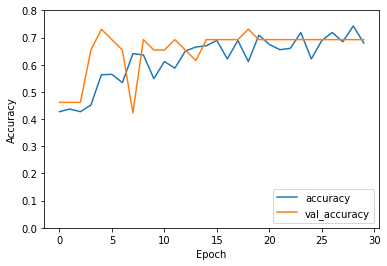

In [341]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.8])
plt.legend(loc='lower right');

#### As you can see from the learning graph validation accuracy is constant after 12th epoch. But accuracy has gone down significantly

In [342]:
# Evaluate the model.

score = model1.evaluate(x_validate, y_validate, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8284777998924255
Test accuracy: 0.692307710647583


### Our first model performed lot better than the second model. Let us stick with our first model and build Confusion matrix

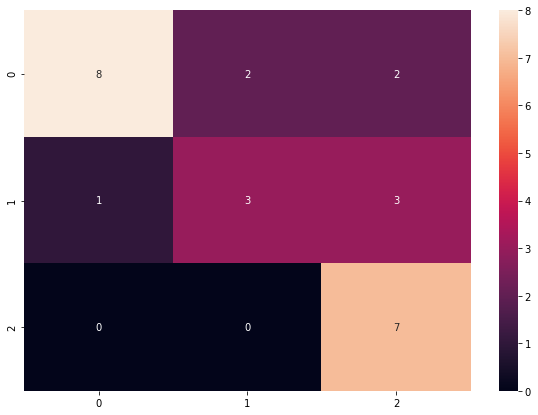

In [343]:
# Predict the values from the validation dataset
Y_pred = model1.predict(x_validate)
# Convert predictions classes to one hot vectors 
result = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate, axis=1)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_true, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 3)],
                  columns = [i for i in range(0, 3)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

### Visulaizing Prediction

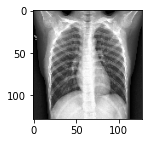

Predicted Label 1
True Label 1


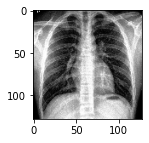

Predicted Label 0
True Label 1


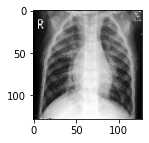

Predicted Label 2
True Label 2


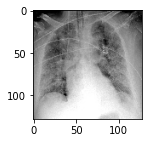

Predicted Label 0
True Label 0


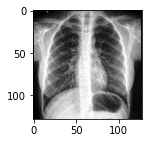

Predicted Label 2
True Label 1


In [344]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[3].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[3]))

plt.figure(figsize=(2,2))
plt.imshow(X_test[2],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(X_test[2].reshape(1,128,128,3))))
print('True Label', np.argmax(y_test[2]))

plt.figure(figsize=(2,2))
plt.imshow(x_validate[9],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(x_validate[9].reshape(1,128,128,3))))
print('True Label', np.argmax(y_validate[9]))

plt.figure(figsize=(2,2))
plt.imshow(x_validate[19],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(x_validate[19].reshape(1,128,128,3))))
print('True Label', np.argmax(y_validate[19]))

plt.figure(figsize=(2,2))
plt.imshow(x_validate[22],cmap="gray")
plt.show()
print('Predicted Label', np.argmax(model1.predict(x_validate[22].reshape(1,128,128,3))))
print('True Label', np.argmax(y_validate[22]))

## Conclusion:
#### The model accuracy becomes constant after the 40th epoch, reducing learning ratedidn't  works well at this time.

#### Data Augmentation is not necessary as intial model gave better result .